This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import logging
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
cam='r9'

import power.PCM as PCM
reload(PCM)

pcm = PCM.PCM(host='pcm-%s' % (cam))
pcm.logger.setLevel(logging.DEBUG)

In [3]:
def gobbleFeeOutput():
    while True:
        ret = fee.readResponse()
        print "got: ", ret
        if ret == '':
            break

def feeUp0():
    print "feeUp0"
    pcm.powerOn('fee')
    time.sleep(4)

def feeUp1():
    global fee
    print "feeUp1"
    logLevel = 20
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp(preset='erase')

def feeUp():
    feeUp0()
    feeUp1()
    
def feeBump():
    print "feeBump"

    pcm.powerCmd('fee', False)
    time.sleep(3)
    feeUp0()

def fullBump():
    feeUp1()
    time.sleep(1.5)
    fee.powerDown()
    time.sleep(1)
    pcm.powerOff('fee')
    
def V1():
    for m in ('erase', 'wipe', 'expose', 'read', 'erase'):
        fee.setMode(m)
        time.sleep(1)
        
def V0():
    feeUp0()
    feeUp1()
    fee.setMode('wipe')
    time.sleep(1)
    fee.setMode('expose')
    time.sleep(1)
    fee.setMode('read')
    ccd.readImage(nrows=40, ncols=100, 
                  clockFunc=pfsClocks, doSave=False)
    fee.setMode('erase')
    time.sleep(1)
#    fee.powerDown()
#    time.sleep(1)
    pcm.powerOff('fee')
    time.sleep(1)
    
#feeUp1()
#time.sleep(2)
#feeBump()
#print fee.doGet('voltage','54VP')


In [6]:
fee.powerDown()
pcm.powerOff('fee')


SUCCESS
SUCCESS
Success


In [7]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

pcm.powerOn('fee')
time.sleep(4)
doLoad = False # '/home/pfs/feeMain-2015-09-11_01.hex'
doCalib = False

logLevel = 20
if doLoad:
    fee = feeMod.FeeControl(logLevel=logLevel, noPowerup=True)
    pcm.powerOff('fee')
    time.sleep(0.5)

    pcm.powerOn('fee')
    fee.sendImage(doLoad)

    time.sleep(2)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel, noPowerup=True)
    fee.saveModesOnFee()
    fee.powerUp()
    
fee = feeMod.FeeControl(logLevel=logLevel)
    
if doCalib:
    fee.raw('lp,read')
    fee.raw('cal,CDS')
    fee.raw('cal,bias')
    #for channel in 0,1:
    #    fee.doSet('bias', 'P_off', -1.0, channel=channel) 
    #    fee.doSet('bias', 'S_off', -1.0, channel=channel)
    #    fee.doSet('bias', 'S_on', 3.0, channel=channel)
    fee.raw('sp,BT1')

    time.sleep(1)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    


Success
SUCCESS
SUCCESS
SUCCESS


In [19]:
fee.logger.setLevel(20)
#gobbleFeeOutput()
#print fee.device.timeout
for i in range(1):
    ccd1 = fee.sendCommandStr('rt,ccd1')
    ccd0 = fee.sendCommandStr('rt,ccd0')
    print "%s %s" % (ccd0, ccd1)

print fee.sendCommandStr('rt,PA')
print fee.sendCommandStr('rt,FEE')

216.52 216.18
246.63
299.42


In [9]:
refSlope = "p"
masterSlope = "n"

fee.zeroOffsets()
defOffsets = np.array([20]*8)
fee.setOffsets(np.arange(8), defOffsets, leg=masterSlope)
# fee.setOffsets(np.arange(8), defOffsets, leg='n')

In [10]:
%pdb off
fee.logger.setLevel(20)
fee.setMode('read')
t0 = time.time()
feeCards = fee.statusAsCards()
t1 = time.time()
fee.setMode('erase')

print "that took %0.3f s" % (t1-t0)
fee.printStatus()



Automatic pdb calling has been turned OFF
that took 2.233 s
bias.ch0.P_on :  -5.03
bias.ch0.P_off :  3.01
bias.ch0.DG_on :  -5.03
bias.ch0.DG_off :  4.99
bias.ch0.S_on :  -6.04
bias.ch0.S_off :  3.01
bias.ch0.SW_on :  -6.04
bias.ch0.SW_off :  4.99
bias.ch0.RG_on :  -7.57
bias.ch0.RG_off :  2.01
bias.ch0.OG :  -4.54
bias.ch0.RD :  -11.8
bias.ch0.OD :  -19.68
bias.ch0.BB :  28.8
bias.ch1.P_on :  -5.04
bias.ch1.P_off :  3.01
bias.ch1.DG_on :  -5.04
bias.ch1.DG_off :  4.99
bias.ch1.S_on :  -6.04
bias.ch1.S_off :  3.01
bias.ch1.SW_on :  -6.04
bias.ch1.SW_off :  4.99
bias.ch1.RG_on :  -7.57
bias.ch1.RG_off :  2.01
bias.ch1.OG :  -4.54
bias.ch1.RD :  -11.81
bias.ch1.OD :  -19.67
bias.ch1.BB :  28.83
voltage.3V3M :  3.29
voltage.3V3 :  3.26
voltage.5VP :  4.95
voltage.5VN :  -4.93
voltage.5VPpa :  4.96
voltage.5VNpa :  -4.86
voltage.12VP :  11.57
voltage.12VN :  -11.67
voltage.24VN :  -23.01
voltage.54VP :  49.12
offset.ch0.0p :  0.07
offset.ch0.1p :  20.06
offset.ch0.2p :  0.04
offset.ch0.3p 

In [70]:
cmds = 'gb', 'rb'
chans = 'ch0', 'ch1'

fee.logger.setLevel(20)
for mode in 'erase', 'expose', 'read', 'wipe':
    fee.setMode(mode)

    print "======== %s" % mode
    
    for k in fee.allKeys('bias'):
        print "%-8s " % k,
        for chan in chans:
            for cmd in cmds:
                v = fee.sendCommandStr('%s,%s,%s' % (cmd, k, chan))
                print "%6s " % (v),
            print "    ",
        print
    
fee.setMode('erase')


======== erase
P_on        6.00    5.99         6.00    5.99      
P_off       6.00    5.99         6.00    5.99      
DG_on       6.00    5.99         6.00    5.99      
DG_off      6.00    5.99         6.00    5.99      
S_on        6.00    5.99         6.00    5.99      
S_off       6.00    5.99         6.00    5.99      
SW_on       6.00    5.99         6.00    5.99      
SW_off      6.00    6.04         6.00    6.04      
RG_on       6.00    6.00         6.00    6.00      
RG_off      6.00    6.00         6.00    6.00      
OG          6.00    6.00         6.00    5.99      
RD        -12.00  -11.73       -12.00  -11.73      
OD         -5.00   -4.76        -5.00   -4.75      
BB          0.20    0.00         0.20    0.00      
======== expose
P_on       -5.00   -5.03        -5.00   -5.03      
P_off       3.00    3.01         3.00    3.01      
DG_on      -5.00   -5.03        -5.00   -5.03      
DG_off      5.00    4.99         5.00    4.99      
S_on       -6.00   -6.04        -

In [128]:
if True:
    fee.device.setTimeout(2.0)
    print fee.saveModesToFee()
    fee.device.setTimeout(0.5)

None


In [10]:
if False:
    print fee.doGet('serial', 'FEE')
    fee.unlockConfig()
    fee.setSerial('ADC', 3063060)
    fee.setSerial('PA0', 186)
    fee.lockConfig()
print fee.doGet('serial', 'FEE')
print fee.doGet('serial', 'ADC')
print fee.doGet('serial', 'PA0')


3060349
3063061
196


In [11]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [12]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_002.readClocks
pre, pix, post = pfsClocks()


0100 65308.3 65283.3 65260.1 65283.2 65306.8 65307.8 65302.4 65281.4 0.54 0.58 0.56 0.57 0.55 0.57 0.58 0.61 OK
0199 65308.3 65283.3 65260.2 65283.3 65306.8 65307.9 65302.5 65281.4 0.57 0.59 0.52 0.59 0.56 0.54 0.59 0.59 OK
0100 65308.3 65283.3 65260.1 65283.2 65306.7 65307.9 65302.3 65281.3 0.58 0.55 0.54 0.58 0.56 0.55 0.58 0.56 OK
0199 65308.2 65283.3 65260.1 65283.3 65306.8 65307.8 65302.4 65281.3 0.56 0.61 0.54 0.58 0.57 0.59 0.58 0.56 OK
!!!! unwraping 857600 pixels !!!!
means(0.000): [-226.7687 -251.7065 -274.9191 -251.6691 -228.2484 -227.1343 -232.5924 -253.6611]
devs (0.000): [0.5564 0.5773 0.5455 0.5826 0.5683 0.5598 0.5736 0.5899]

0100 2588.2 2547.6 2519.0 2565.3 2533.7 2575.7 2560.5 2528.8 0.53 0.57 0.53 0.58 0.57 0.56 0.55 0.56 OK
0199 2588.3 2547.7 2519.0 2565.4 2533.8 2575.8 2560.6 2528.9 0.55 0.58 0.56 0.60 0.53 0.53 0.57 0.60 OK
!!!! unwraping 8 pixels !!!!
means(39.600): [2588.2835 2547.5833 2518.9904 2565.2973 2533.6544 2575.6591 2560.5045 2528.6680]
devs (39.600): 

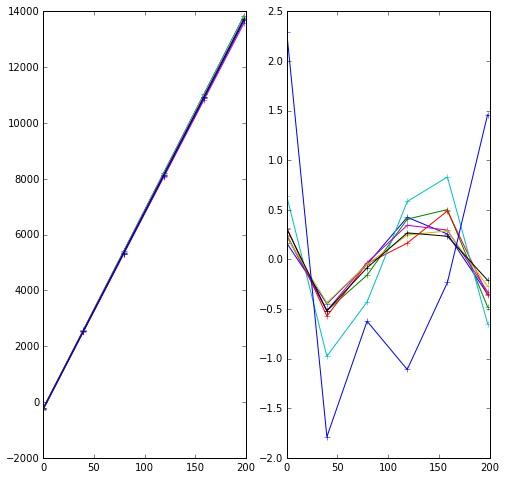

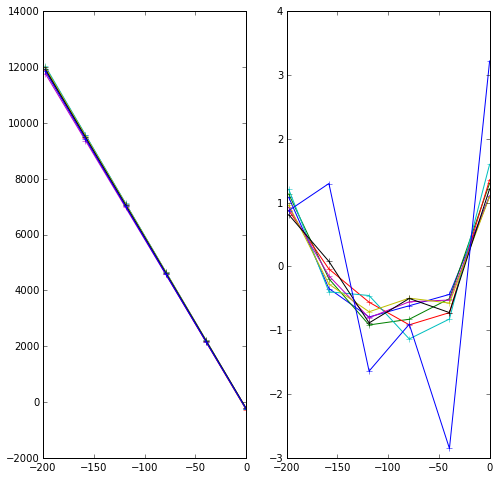

In [16]:
reload(nbFuncs)

doGainCurve = True
if doGainCurve:
    fee.zeroOffsets()
    stepSize = 2*19.8
    statCols = slice(5,None)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', 
                                          statCols=statCols, doUnwrap=65000, clockFunc=pfsClocks)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', 
                                          statCols=statCols, doUnwrap=65000, clockFunc=pfsClocks)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [22]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 5
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 10
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = False
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='np', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=65000)

    defOffsets = offs


Automatic pdb calling has been turned OFF


0300 51290.9 49778.9 49585.7 50532.5 40556.7 26858.4 31148.1 22520.3 10.70 3.34 3.37 7.43 419.36 661.39 578.53 549.30 OK
0600 51286.8 49775.8 49581.4 50527.2 40510.1 26888.1 31220.5 22597.9 8.58 3.13 3.21 6.10 437.97 663.89 589.90 554.73 OK
0900 51281.6 49774.8 49579.9 50524.6 40572.3 26957.2 31304.1 22681.8 3.47 3.16 3.42 3.27 433.20 683.72 604.82 571.71 OK
1200 51279.3 49775.1 49579.5 50524.6 40551.3 27020.3 31338.8 22761.8 2.92 2.83 3.18 3.03 437.13 686.64 607.76 582.82 OK
1500 51033.6 49774.5 49578.5 50524.5 40679.4 27066.8 31380.5 22867.3 2.98 2.68 3.07 2.82 447.81 699.90 614.98 602.38 OK
1800 51007.8 49713.6 49313.5 50519.9 40661.8 27116.4 31391.3 22883.9 3.37 34.45 1867.95 3.40 446.57 701.64 619.60 604.62 OK
2100 51009.7 49236.8 49079.8 50512.4 40654.7 27129.9 31437.5 22942.7 3.62 2975.39 2726.56 3.20 484.44 696.03 630.22 612.44 OK
2400 51005.1 49204.0 49045.8 50505.7 40764.7 27193.2 31517.1 22998.0 3.77 3072.53 2808.58 21.21 455.38 717.45 637.32 626.31 OK
2700 50923.0 48898.1 4

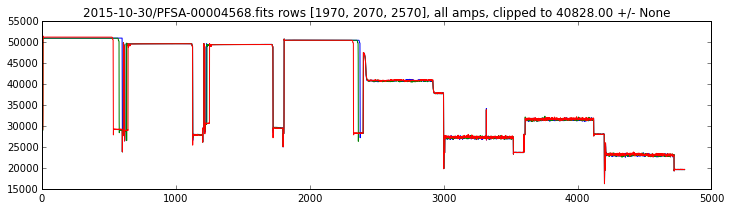

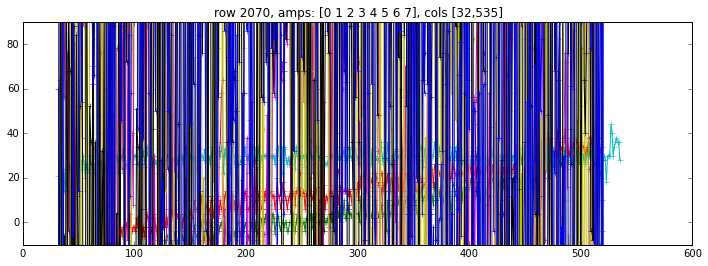

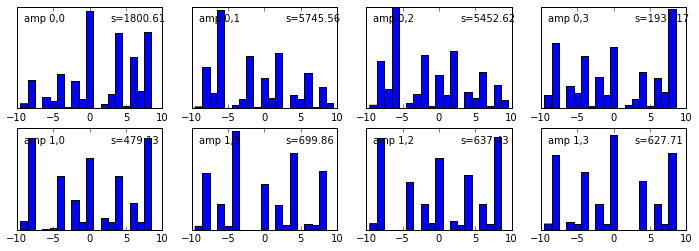

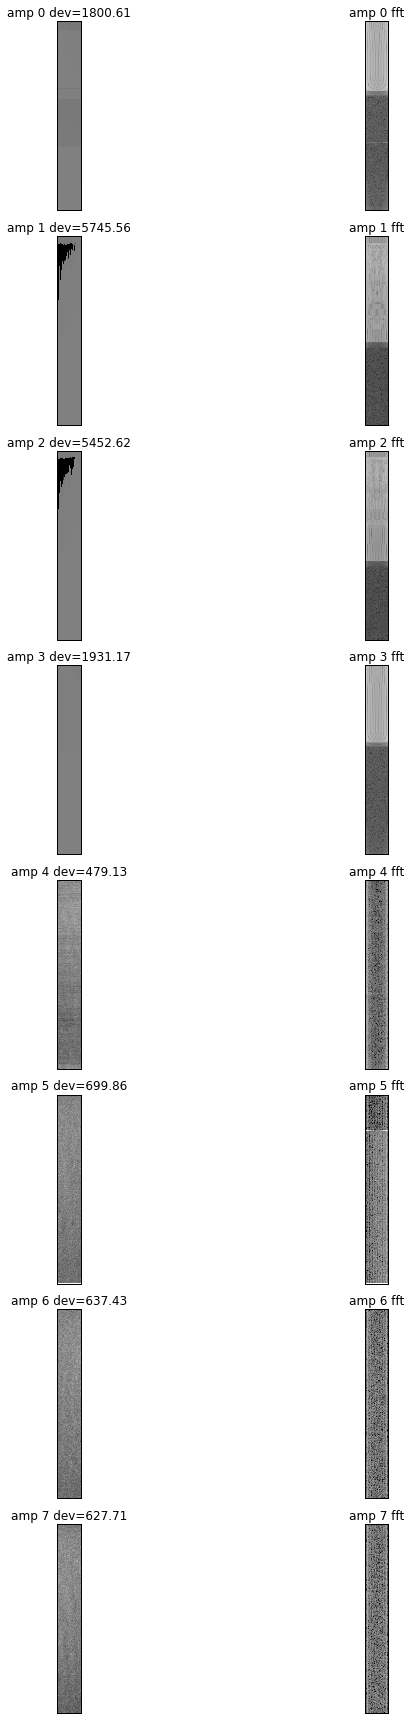

In [18]:
reload(ccdFuncs)
reload(nbFuncs)

fee.setMode('erase')

# fee.sendCommandStr('sf,slow')

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

nrows = 4340          # How many rows to read out.
ncols = 600
selectRows = slice(100,nrows-200)
selectCols = None # slice(5,5)
pcols = np.arange(32,ncols-64)    # Which cols to plot
statCols = np.arange(40,ncols-64) # Which cols to use for stats
prow = (selectRows.stop+1)/2
prows = [prow-100,prow,prow+500]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=300, ampList=goodAmps, cols=statCols, ccd=ccd)

siggenAmp = None
if siggenAmp is None:
    try:
        switch.setCoils(off=range(16))
    except:
        pass
else:
    switch.chooseCoil(siggenAmp)

comment = 'pure test'
flushRead = False
doFile = None # '/data/pfs/2015-06-02/PFSA-00000954.fits'
doSave = True
if doFile:
    im = fitsio.read(doFile)
else:
    fee.setMode('read')
    time.sleep(1)
    if flushRead:
        im, files = ccd.readImage(nrows=100, ncols=ncols, 
                                  rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                  clockFunc=pfsClocks, doSave=False)
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=doSave,
                              comment=comment, addCards=feeCards)
    fee.setMode('erase')

if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
if False:
    hi_w = np.where(im > 63000)
    im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=None, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()